In [23]:
import math 
import time
import numpy as np #library for working with arrays 
import pandas as pd #library that provides various data structures and operations for manipulating numerical data and time series data 
import seaborn as sns #library for statistical graphics on python 
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
from keras.models import Sequential 
from keras.callbacks import EarlyStopping
from keras.layers import LSTM, Dense, Dropout
from datetime import date, timedelta, datetime
from pandas.plotting import register_matplotlib_converters
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [24]:
#Downloading hostorical stock price data from 1st Jan 2017 to today
stockname = 'AAPL'
interval = '1d' 
date_today = date.today()
date_start = datetime.strptime('2017-01-01', "%Y-%m-%d")
#fetching the data from API
period1 = int(time.mktime(date_start.timetuple()))
period2 = int(time.mktime(date_today.timetuple()))
query_string = f'https://query1.finance.yahoo.com/v7/finance/download/{stockname}?period1={period1}&period2={period2}&interval={interval}&events=history&includeAdjustedClose=true'

#Saving data to CSV file
stocks_data = pd.read_csv(query_string)
stocks_data.to_csv(stockname + '.csv')

#Loading data into dataframe
df = pd.read_csv(stockname + '.csv',parse_dates = True,index_col=['Date'])
df = df.drop(['Unnamed: 0'],axis=1)

In [25]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-03,28.950001,29.082500,28.690001,29.037500,27.133329,115127600
2017-01-04,28.962500,29.127501,28.937500,29.004999,27.102953,84472400
2017-01-05,28.980000,29.215000,28.952499,29.152500,27.240786,88774400
2017-01-06,29.195000,29.540001,29.117500,29.477501,27.544468,127007600
2017-01-09,29.487499,29.857500,29.485001,29.747499,27.796762,134247600
...,...,...,...,...,...,...
2023-02-17,152.350006,153.000000,150.850006,152.550003,152.550003,59095900
2023-02-21,150.199997,151.300003,148.410004,148.479996,148.479996,58867200
2023-02-22,148.869995,149.949997,147.160004,148.910004,148.910004,51011300


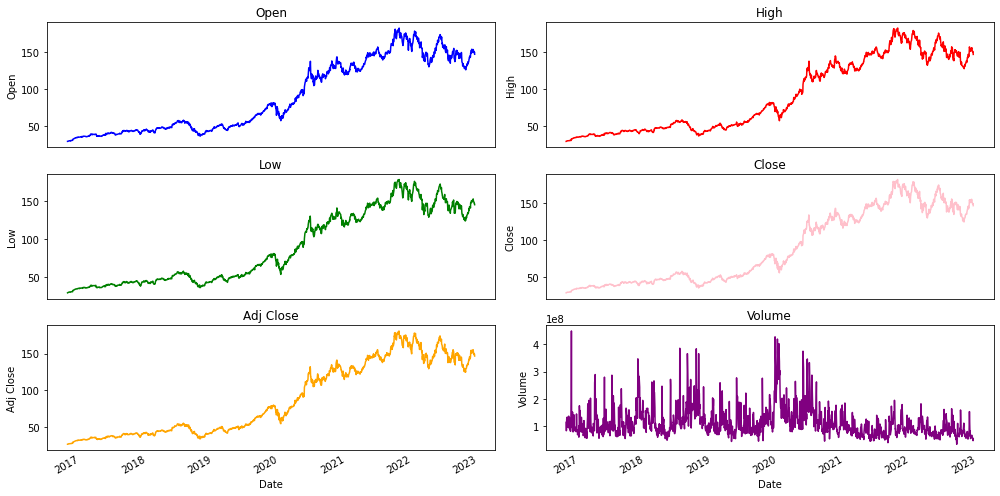

In [26]:
# Plotting line charts
df_plot = df.copy() #creates copy of existing dataframe
list_length = df_plot.shape[1] #returns the number of coloumns, as .shape returns the rows and coloums of dataframe
ncols = 2
nrows = int(round(list_length / ncols, 0)) #rounds off list_length / ncols to 0 number of decimal digits 
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(14, 7)) 
fig.subplots_adjust(hspace=0.5, wspace=0.5)
colors = ['blue', 'red', 'green', 'pink', 'orange', 'purple']
for i in range(0, list_length):
        ax = plt.subplot(nrows,ncols,i+1)
        sns.lineplot(data = df_plot.iloc[:, i], ax=ax, color= colors[i])
        ax.set_title(df_plot.columns[i])
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())

fig.tight_layout()
plt.show()

In [27]:
# Creating n samples, sequence_length time steps per samples
def splitData(sequence_length, data, index_Close):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        #contains sequence_length values 0-sequence_length * columns
        x.append(data[i-sequence_length:i,:]) 
        #contains the prediction values for validation,  for single-step prediction
        y.append(data[i, index_Close]) 
    # Convert the x & y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

def processData(df, FEATURES):
  # Indexing  the batches
  train_df = df.sort_values(by=['Date']).copy()
  # Saving a copy of the dates index, before we need to reset it to numbers
  date_index = train_df.index
  # Reset the index, so we can convert the date-index to a number-index
  train_df = train_df.reset_index(drop=True).copy()
  # Create the dataset with features and filter the data to the list of FEATURES
  data = pd.DataFrame(train_df)
  data_filtered = data[FEATURES]

  # Adding a prediction column (target varaible) and setting dummy values to prepare the data for scaling
  data_filtered_ext = data_filtered.copy()
  data_filtered_ext['Prediction'] = data_filtered_ext['Close']
  # Number of rows in the data
  nrows = data_filtered.shape[0]
  # Convert data to numpy values
  np_data_unscaled = np.array(data_filtered)
  np_data = np.reshape(np_data_unscaled, (nrows, -1))

  # Transform the data by scaling each feature to a range between 0 and 1
  scaler = MinMaxScaler()
  np_data_scaled = scaler.fit_transform(np_data_unscaled)
  # Creating a separate scaler that works on a single column for scaling predictions
  scaler_pred = MinMaxScaler()
  df_Close = pd.DataFrame(data_filtered_ext['Close'])
  np_Close_scaled = scaler_pred.fit_transform(df_Close)

  # sequence length: this is the timeframe used to make a single prediction
  sequence_length = 50
  # Prediction Index
  index_Close = data.columns.get_loc("Close")
  # Split the training data into train and test datasets with 80:20 split 
  train_data_len = math.ceil(np_data_scaled.shape[0] * 0.8)
  # Creating the training and test data
  train_data = np_data_scaled[0:train_data_len, :]
  test_data = np_data_scaled[train_data_len - sequence_length:, :]

  # Generate training data and test data
  x_train, y_train = splitData(sequence_length, train_data, index_Close)
  x_test, y_test = splitData(sequence_length, test_data, index_Close)

  return x_train, y_train, x_test, y_test, data_filtered, \
         date_index, scaler, scaler_pred, train_data_len, sequence_length


In [28]:
#Setting up LSTM model architecture

def getModel(x_train):
  # Creating model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
  model = Sequential()
  n_neurons = x_train.shape[1] * x_train.shape[2]
  model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
  model.add(LSTM(n_neurons, return_sequences=False))
  model.add(Dense(5))
  model.add(Dense(1))

  # Compiling the model
  model.compile(optimizer='adam', loss='mse')
  return model

In [29]:
def plotLossCurve(history, color, title):
  # Plot the Loss Curve
  fig, ax = plt.subplots(figsize=(7, 6), sharex=True)
  plt.plot(history.history["loss"],color=color)
  plt.title(title)
  plt.ylabel("Loss")
  plt.xlabel("Epoch")
  plt.xticks(rotation=45)
  plt.legend(["Train", "Test"], loc="upper left")
  plt.show()

In [30]:
def eval(model, x_test, y_test, scaler_pred):
  # Get the predicted values
  y_pred_scaled = model.predict(x_test)
  # Unscale the predicted values
  y_pred = scaler_pred.inverse_transform(y_pred_scaled)
  y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

  # Mean Absolute Error (MAE)
  MAE = mean_absolute_error(y_test_unscaled, y_pred)
  print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

  # Mean Absolute Percentage Error (MAPE)
  MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
  print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

  # Median Absolute Percentage Error (MDAPE)
  MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
  print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

  return MAE, MAPE, MDAPE, y_pred

In [31]:
def visualizePreds(data_filtered, train_data_len, y_pred, date_index, color):
  # The date from which on the date is displayed
  display_start_date = pd.Timestamp('today') - timedelta(days=500)
  # Add the date column
  data_filtered_sub = data_filtered.copy()
  data_filtered_sub['Date'] = date_index

  # Add the difference between the valid and predicted prices
  train = data_filtered_sub[:train_data_len + 1]
  valid = data_filtered_sub[train_data_len:]
  
  valid.insert(1, "Prediction", y_pred.ravel(), True)
  valid.insert(1, "Difference", valid["Prediction"] - valid["Close"], True)
  # Zoom in to a closer timeframe
  valid = valid[valid['Date'] > display_start_date]
  train = train[train['Date'] > display_start_date]
  
  # Visualize the data
  fig, ax1 = plt.subplots(figsize=(10, 7), sharex=True)
  xt = train['Date']; yt = train[["Close"]]
  xv = valid['Date']; yv = valid[["Close", "Prediction"]]
  plt.title("Predictions vs Actual Values", fontsize=20)
  plt.ylabel(stockname, fontsize=18)
  plt.plot(xt, yt, color="green", linewidth=2.0)
  plt.plot(xv, yv["Prediction"], color=color, linewidth=2.0)
  plt.plot(xv, yv["Close"], color="black", linewidth=2.0)
  plt.legend(["Train", "Test Predictions", "Actual Values"], loc="upper left")
  plt.show()

In [32]:
def predictFuturePrice(model, df, sequence_length, feats, scaler, scaler_pred):
  df_temp = df[-sequence_length:]
  new_df = df_temp.filter(feats)
  N = sequence_length
  # Get the last N day closing price values and scale the data to be values between 0 and 1
  last_N_days = new_df[-sequence_length:].values
  last_N_days_scaled = scaler.transform(last_N_days)

  # Create an empty list and Append past N days
  X_test_new = []
  X_test_new.append(last_N_days_scaled)
  # Convert the X_test data set to a numpy array and reshape the data
  pred_price_scaled = model.predict(np.array(X_test_new))
  pred_price_unscaled = scaler_pred.inverse_transform(pred_price_scaled.reshape(-1, 1))
  # Print last price and predicted price for the next day
  price_today = np.round(new_df['Close'][-1], 2)
  predicted_price = np.round(pred_price_unscaled.ravel()[0], 2)
  change_percent = np.round(100 - (price_today * 100)/predicted_price, 2)

  plus = '+'; minus = ''
  print(f'The close price for {stockname} at {date_today} was {price_today}')
  print(f'The predicted close price is {predicted_price} ({plus if change_percent > 0 else minus}{change_percent}%)')

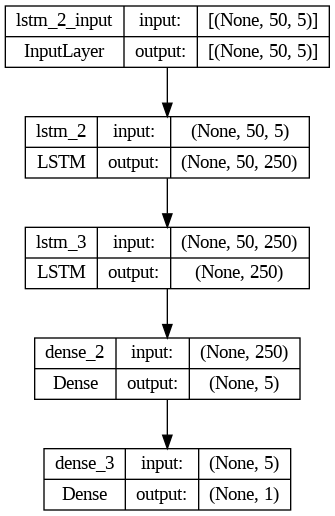

In [33]:
# List of considered features
features1 = ['High', 'Low', 'Open', 'Close', 'Volume']  
# Split and process dataset
x_train1, y_train1, x_test1, y_test1, data_filtered1, date_index1, \
scaler1, scaler_pred1, train_data_len1, sequence_length1 = processData(df, features1)
# Get Model
model1 = getModel(x_train1)
#Visualizing Model Architecture
import tensorflow as tf
tf.keras.utils.plot_model(model1, show_shapes=True)

In [34]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 50, 250)           256000    
                                                                 
 lstm_3 (LSTM)               (None, 250)               501000    
                                                                 
 dense_2 (Dense)             (None, 5)                 1255      
                                                                 
 dense_3 (Dense)             (None, 1)                 6         
                                                                 
Total params: 758,261
Trainable params: 758,261
Non-trainable params: 0
_________________________________________________________________


In [35]:
# Training the model
epochs = 50
history1 = model1.fit(x_train1, y_train1, batch_size=512, epochs=epochs, validation_data=(x_test1, y_test1),\
                     callbacks=[EarlyStopping(monitor='loss', patience=5, verbose=1)])


Epoch 1/50
3/3 [==============================] - 15s 3s/step - loss: 0.0914 - val_loss: 0.0064
Epoch 2/50
3/3 [==============================] - 9s 3s/step - loss: 0.0072 - val_loss: 0.0175
Epoch 3/50
3/3 [==============================] - 9s 3s/step - loss: 0.0026 - val_loss: 0.0326
Epoch 4/50
3/3 [==============================] - 7s 2s/step - loss: 0.0056 - val_loss: 0.0023
Epoch 5/50
3/3 [==============================] - 9s 3s/step - loss: 0.0017 - val_loss: 0.0158
Epoch 6/50
3/3 [==============================] - 7s 2s/step - loss: 0.0029 - val_loss: 0.0021
Epoch 7/50
3/3 [==============================] - 8s 2s/step - loss: 8.3946e-04 - val_loss: 0.0051
Epoch 8/50
3/3 [==============================] - 8s 3s/step - loss: 0.0016 - val_loss: 0.0017
Epoch 9/50
3/3 [==============================] - 7s 2s/step - loss: 5.1857e-04 - val_loss: 0.0050
Epoch 10/50
3/3 [==============================] - 9s 3s/step - loss: 0.0010 - val_loss: 0.0023
Epoch 11/50
3/3 [=======================

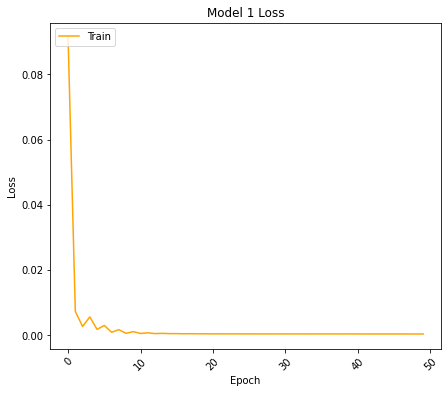

In [36]:
# Plotting Loss Curve
plotLossCurve(history1,"orange", "Model 1 Loss")   

In [37]:
# Evaluating model
MAE1, MAPE1, MDAPE1, y_pred1= eval(model1, x_test1, y_test1, scaler_pred1)

10/10 [==============================] - 2s 110ms/step
Median Absolute Error (MAE): 4.88
Mean Absolute Percentage Error (MAPE): 3.16 %
Median Absolute Percentage Error (MDAPE): 2.96 %


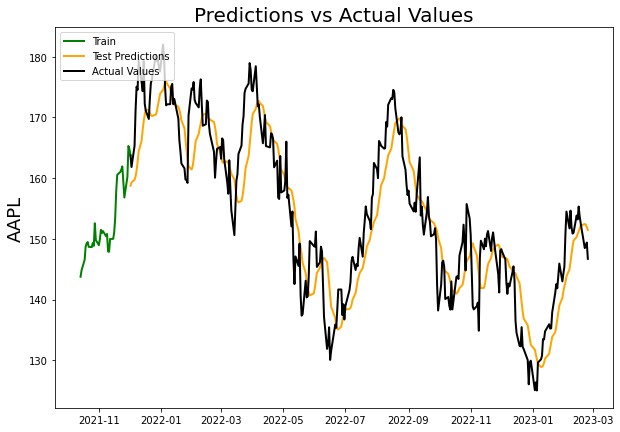

In [38]:
# Visualising Predictions
visualizePreds(data_filtered1, train_data_len1, y_pred1, date_index1, "orange")

In [39]:
#Predicting Next Day's Price
predictFuturePrice(model1, df, sequence_length1, features1, scaler1, scaler_pred1)

1/1 [==============================] - 0s 45ms/step
The close price for AAPL at 2023-02-25 was 146.71
The predicted close price is 150.8000030517578 (+2.71%)
